In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid")


In [2]:
# Upload CSV from local machine
from google.colab import files
uploaded = files.upload()

Saving ncd_mortality_rate.csv to ncd_mortality_rate.csv


In [5]:
# Load dataset
df = pd.read_csv("ncd_mortality_rate.csv")
df.head()

,Id,IndicatorCode,SpatialDimension,SpatialDimensionValueCode,ParentLocationCode,ParentLocation,TimeDimension,TimeDim,DisaggregatingDimension1,DisaggregatingDimension1ValueCode,...,DataSourceDimensionValueCode,Value,NumericValue,Low,High,Comments,Date,TimeDimensionValue,TimeDimensionBegin,TimeDimensionEnd
0,2580,WHS2_131,COUNTRY,MNG,WPR,Western Pacific,YEAR,2008,SEX,SEX_MLE,...,NaN,1150 [800-1640],1154.45361,795.56970,1643.54529,NaN,2025-03-19T11:00:50Z,2008,2008-01-01,2008-12-31
1,3178,WHS2_131,COUNTRY,UKR,EUR,Europe,YEAR,2007,SEX,SEX_FMLE,...,NaN,650 [570-750],648.86377,566.58667,750.62085,NaN,2025-03-19T11:00:50Z,2007,2007-01-01,2007-12-31
2,8700,WHS2_131,REGION,SEAR,NaN,NaN,YEAR,2014,SEX,SEX_FMLE,...,NaN,510 [370-720],513.12555,367.81766,723.47229,NaN,2025-03-19T11:00:50Z,2014,2014-01-01,2014-12-31
3,9099,WHS2_131,COUNTRY,ARE,EMR,Eastern Mediterranean,YEAR,2013,SEX,SEX_MLE,...,NaN,340 [210-510],336.01038,214.67542,507.79584,NaN,2025-03-19T11:00:50Z,2013,2013-01-01,2013-12-31
4,9591,WHS2_131,COUNTRY,CHE,EUR,Europe,YEAR,2013,SEX,SEX_FMLE,...,NaN,250 [180-330],245.98584,177.09818,328.02176,NaN,2025-03-19T11:00:50Z,2013,2013-01-01,2013-12-31


In [11]:
# CLEANING & TRANSFORMATION
# Reload original dataset if needed
df = pd.read_csv("ncd_mortality_rate.csv")

# Filter only male and female
df = df[df['DisaggregatingDimension1ValueCode'].isin(['SEX_MLE', 'SEX_FMLE'])]

# Rename correctly
df = df.rename(columns={
    'ParentLocation': 'Country',
    'TimeDimensionValue': 'Year',
    'DisaggregatingDimension1ValueCode': 'Sex',
    'NumericValue': 'NCD_Mortality_Rate'
})

# Replace codes
df['Sex'] = df['Sex'].replace({
    'SEX_MLE': 'Male',
    'SEX_FMLE': 'Female'
})

# Keep what you need
df_clean = df[['Country', 'Year', 'Sex', 'NCD_Mortality_Rate']].dropna()

# Confirm values look correct
df_clean.head()


,Country,Year,Sex,NCD_Mortality_Rate
0,Western Pacific,2008,Male,1154.45361
1,Europe,2007,Female,648.86377
3,Eastern Mediterranean,2013,Male,336.01038
4,Europe,2013,Female,245.98584
5,Africa,2012,Male,704.81384


In [12]:
print("Shape:", df_clean.shape)
df_clean.head(10)

Shape: (8140, 4)


,Country,Year,Sex,NCD_Mortality_Rate
0,Western Pacific,2008,Male,1154.45361
1,Europe,2007,Female,648.86377
3,Eastern Mediterranean,2013,Male,336.01038
4,Europe,2013,Female,245.98584
5,Africa,2012,Male,704.81384
6,Americas,2020,Female,295.44336
7,Africa,2005,Male,839.15137
9,Americas,2018,Male,447.86087
14,Americas,2001,Female,527.29608
15,Americas,2009,Female,351.31512


In [13]:
df_clean.to_csv("ncd_gender_cleaned.csv", index=False)


In [14]:
from google.colab import files
files.download("ncd_gender_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         count        mean         std        min         25%         50%  \
Sex                                                                         
Female  4312.0  509.248084  168.296623  161.91096  381.038815  499.581800   
Male    4312.0  680.281410  212.757167  235.82047  524.784623  656.576445   

               75%         max  
Sex                             
Female  608.322375  1202.87268  
Male    798.391433  1496.53516  


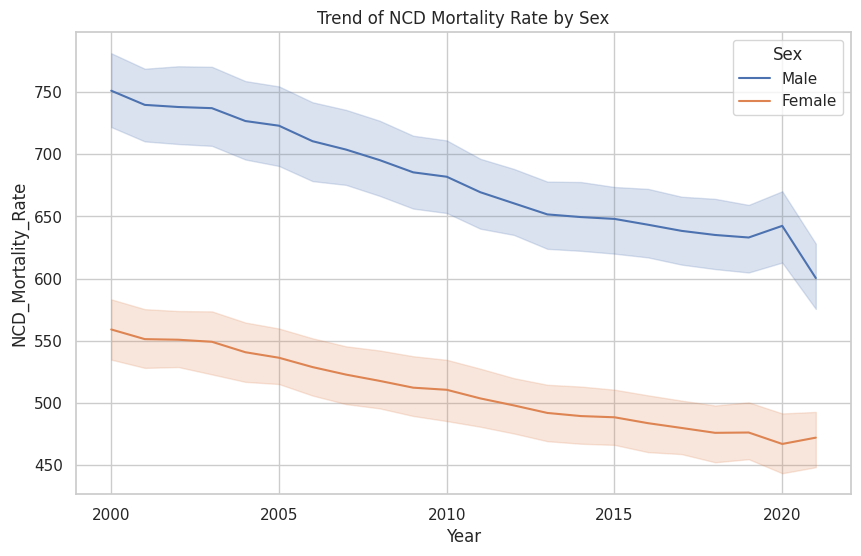

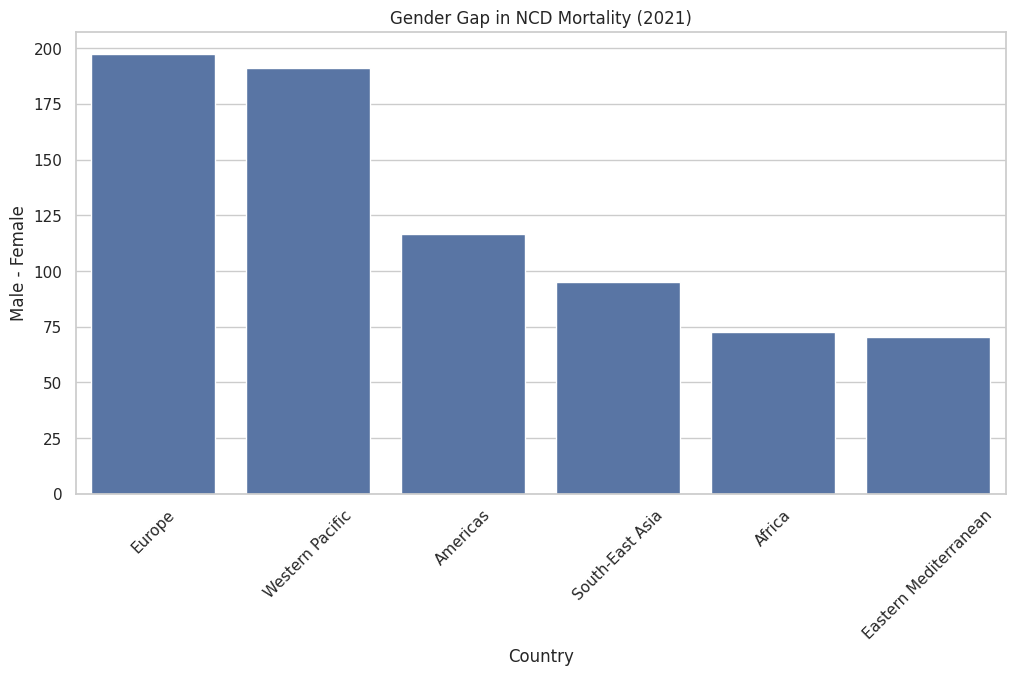

In [16]:
# 4. EXPLORATORY DATA ANALYSIS
# Descriptive Stats
print(df.groupby("Sex")["NCD_Mortality_Rate"].describe())

# NCD Trend by Sex Over Time
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="Year", y="NCD_Mortality_Rate", hue="Sex")
plt.title("Trend of NCD Mortality Rate by Sex")
plt.show()

# Gender Difference by Region for Latest Year
latest = df['Year'].max()
df_latest = df[df['Year'] == latest]

pivot = df_latest.pivot_table(
    index='Country',
    columns='Sex',
    values='NCD_Mortality_Rate',
    aggfunc='mean'  # Resolves duplicates by averaging
).dropna()
pivot['Difference'] = pivot['Male'] - pivot['Female']
pivot_sorted = pivot.sort_values('Difference', ascending=False)

# Bar Chart of Gender Difference
plt.figure(figsize=(12,6))
sns.barplot(x=pivot_sorted.index, y=pivot_sorted['Difference'])
plt.xticks(rotation=45)
plt.title(f"Gender Gap in NCD Mortality ({latest})")
plt.ylabel("Male - Female")
plt.show()

Silhouette Score: 0.19


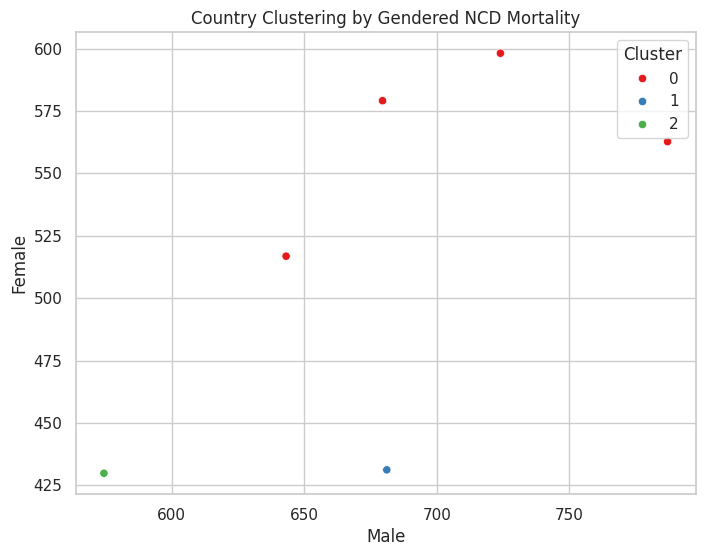

In [17]:
# 5. MODELING: KMeans Clustering
# Prepare data for clustering
pivot_kmeans = df.pivot_table(index='Country', columns='Sex', values='NCD_Mortality_Rate').dropna()
scaler = StandardScaler()
scaled = scaler.fit_transform(pivot_kmeans)

kmeans = KMeans(n_clusters=3, random_state=42)
pivot_kmeans['Cluster'] = kmeans.fit_predict(scaled)

# Silhouette Score
score = silhouette_score(scaled, pivot_kmeans['Cluster'])
print(f"Silhouette Score: {score:.2f}")

# Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=pivot_kmeans, x='Male', y='Female', hue='Cluster', palette='Set1')
plt.title("Country Clustering by Gendered NCD Mortality")
plt.show()

In [18]:
# 6. EXPORT CLEANED DATA (Optional)
df.to_csv("ncd_gender_cleaned.csv", index=False)

In [19]:
# 7. CONCLUSION
print("Analysis complete. Gender disparities in NCD mortality vary by country and cluster analysis reveals patterns.")


Analysis complete. Gender disparities in NCD mortality vary by country and cluster analysis reveals patterns.
